In [1]:
import numpy as np
from numpy.core.overrides import array_function_dispatch
from numpy.lib.index_tricks import ndindex

def _as_pairs(x, ndim, as_index=False):
    """
    Broadcast `x` to an array with the shape (`ndim`, 2).
    A helper function for `pad` that prepares and validates arguments like
    `pad_width` for iteration in pairs.
    Parameters
    ----------
    x : {None, scalar, array-like}
        The object to broadcast to the shape (`ndim`, 2).
    ndim : int
        Number of pairs the broadcasted `x` will have.
    as_index : bool, optional
        If `x` is not None, try to round each element of `x` to an integer
        (dtype `np.intp`) and ensure every element is positive.
    Returns
    -------
    pairs : nested iterables, shape (`ndim`, 2)
        The broadcasted version of `x`.
    Raises
    ------
    ValueError
        If `as_index` is True and `x` contains negative elements.
        Or if `x` is not broadcastable to the shape (`ndim`, 2).
    """
    if x is None:
        # Pass through None as a special case, otherwise np.round(x) fails
        # with an AttributeError
        return ((None, None),) * ndim

    x = np.array(x)
    if as_index:
        x = np.round(x).astype(np.intp, copy=False)

    if x.ndim < 3:
        # Optimization: Possibly use faster paths for cases where `x` has
        # only 1 or 2 elements. `np.broadcast_to` could handle these as well
        # but is currently slower

        if x.size == 1:
            # x was supplied as a single value
            x = x.ravel()  # Ensure x[0] works for x.ndim == 0, 1, 2
            if as_index and x < 0:
                raise ValueError("index can't contain negative values")
            return ((x[0], x[0]),) * ndim

        if x.size == 2 and x.shape != (2, 1):
            # x was supplied with a single value for each side
            # but except case when each dimension has a single value
            # which should be broadcasted to a pair,
            # e.g. [[1], [2]] -> [[1, 1], [2, 2]] not [[1, 2], [1, 2]]
            x = x.ravel()  # Ensure x[0], x[1] works
            if as_index and (x[0] < 0 or x[1] < 0):
                raise ValueError("index can't contain negative values")
            return ((x[0], x[1]),) * ndim

    if as_index and x.min() < 0:
        raise ValueError("index can't contain negative values")

    # Converting the array with `tolist` seems to improve performance
    # when iterating and indexing the result (see usage in `pad`)
    return np.broadcast_to(x, (ndim, 2)).tolist()


def pad(array, pad_width, mode='constant', **kwargs):
    """
    Pad an array.
    Parameters
    ----------
    array : array_like of rank N
        The array to pad.
    pad_width : {sequence, array_like, int}
        Number of values padded to the edges of each axis.
        ((before_1, after_1), ... (before_N, after_N)) unique pad widths
        for each axis.
        ((before, after),) yields same before and after pad for each axis.
        (pad,) or int is a shortcut for before = after = pad width for all
        axes.
    mode : str or function, optional
        One of the following string values or a user supplied function.
        'constant' (default)
            Pads with a constant value.
        'edge'
            Pads with the edge values of array.
        'linear_ramp'
            Pads with the linear ramp between end_value and the
            array edge value.
        'maximum'
            Pads with the maximum value of all or part of the
            vector along each axis.
        'mean'
            Pads with the mean value of all or part of the
            vector along each axis.
        'median'
            Pads with the median value of all or part of the
            vector along each axis.
        'minimum'
            Pads with the minimum value of all or part of the
            vector along each axis.
        'reflect'
            Pads with the reflection of the vector mirrored on
            the first and last values of the vector along each
            axis.
        'symmetric'
            Pads with the reflection of the vector mirrored
            along the edge of the array.
        'wrap'
            Pads with the wrap of the vector along the axis.
            The first values are used to pad the end and the
            end values are used to pad the beginning.
        'empty'
            Pads with undefined values.
            .. versionadded:: 1.17
        <function>
            Padding function, see Notes.
    stat_length : sequence or int, optional
        Used in 'maximum', 'mean', 'median', and 'minimum'.  Number of
        values at edge of each axis used to calculate the statistic value.
        ((before_1, after_1), ... (before_N, after_N)) unique statistic
        lengths for each axis.
        ((before, after),) yields same before and after statistic lengths
        for each axis.
        (stat_length,) or int is a shortcut for before = after = statistic
        length for all axes.
        Default is ``None``, to use the entire axis.
    constant_values : sequence or scalar, optional
        Used in 'constant'.  The values to set the padded values for each
        axis.
        ``((before_1, after_1), ... (before_N, after_N))`` unique pad constants
        for each axis.
        ``((before, after),)`` yields same before and after constants for each
        axis.
        ``(constant,)`` or ``constant`` is a shortcut for ``before = after = constant`` for
        all axes.
        Default is 0.
    end_values : sequence or scalar, optional
        Used in 'linear_ramp'.  The values used for the ending value of the
        linear_ramp and that will form the edge of the padded array.
        ``((before_1, after_1), ... (before_N, after_N))`` unique end values
        for each axis.
        ``((before, after),)`` yields same before and after end values for each
        axis.
        ``(constant,)`` or ``constant`` is a shortcut for ``before = after = constant`` for
        all axes.
        Default is 0.
    reflect_type : {'even', 'odd'}, optional
        Used in 'reflect', and 'symmetric'.  The 'even' style is the
        default with an unaltered reflection around the edge value.  For
        the 'odd' style, the extended part of the array is created by
        subtracting the reflected values from two times the edge value.
    Returns
    -------
    pad : ndarray
        Padded array of rank equal to `array` with shape increased
        according to `pad_width`.
    Notes
    -----
    .. versionadded:: 1.7.0
    For an array with rank greater than 1, some of the padding of later
    axes is calculated from padding of previous axes.  This is easiest to
    think about with a rank 2 array where the corners of the padded array
    are calculated by using padded values from the first axis.
    The padding function, if used, should modify a rank 1 array in-place. It
    has the following signature::
        padding_func(vector, iaxis_pad_width, iaxis, kwargs)
    where
        vector : ndarray
            A rank 1 array already padded with zeros.  Padded values are
            vector[:iaxis_pad_width[0]] and vector[-iaxis_pad_width[1]:].
        iaxis_pad_width : tuple
            A 2-tuple of ints, iaxis_pad_width[0] represents the number of
            values padded at the beginning of vector where
            iaxis_pad_width[1] represents the number of values padded at
            the end of vector.
        iaxis : int
            The axis currently being calculated.
        kwargs : dict
            Any keyword arguments the function requires.
    
    """
    array = np.asarray(array)
    pad_width = np.asarray(pad_width)

    if not pad_width.dtype.kind == 'i':
        raise TypeError('`pad_width` must be of integral type.')

    # Broadcast to shape (array.ndim, 2)
    pad_width = _as_pairs(pad_width, array.ndim, as_index=True)

    if callable(mode):
        # Old behavior: Use user-supplied function with np.apply_along_axis
        function = mode
        # Create a new zero padded array
        padded, _ = _pad_simple(array, pad_width, fill_value=0)
        # And apply along each axis

        for axis in range(padded.ndim):
            # Iterate using ndindex as in apply_along_axis, but assuming that
            # function operates inplace on the padded array.

            # view with the iteration axis at the end
            view = np.moveaxis(padded, axis, -1)

            # compute indices for the iteration axes, and append a trailing
            # ellipsis to prevent 0d arrays decaying to scalars (gh-8642)
            inds = ndindex(view.shape[:-1])
            inds = (ind + (Ellipsis,) for ind in inds)
            for ind in inds:
                function(view[ind], pad_width[axis], axis, kwargs)

        return padded

    # Make sure that no unsupported keywords were passed for the current mode
    allowed_kwargs = {
        'empty': [], 'edge': [], 'wrap': [],
        'constant': ['constant_values'],
        'linear_ramp': ['end_values'],
        'maximum': ['stat_length'],
        'mean': ['stat_length'],
        'median': ['stat_length'],
        'minimum': ['stat_length'],
        'reflect': ['reflect_type'],
        'symmetric': ['reflect_type'],
    }
    try:
        unsupported_kwargs = set(kwargs) - set(allowed_kwargs[mode])
    except KeyError:
        raise ValueError("mode '{}' is not supported".format(mode)) from None
    if unsupported_kwargs:
        raise ValueError("unsupported keyword arguments for mode '{}': {}"
                         .format(mode, unsupported_kwargs))

    stat_functions = {"maximum": np.amax, "minimum": np.amin,
                      "mean": np.mean, "median": np.median}

    # Create array with final shape and original values
    # (padded area is undefined)
    padded, original_area_slice = _pad_simple(array, pad_width)
    # And prepare iteration over all dimensions
    # (zipping may be more readable than using enumerate)
    axes = range(padded.ndim)

    if mode == "constant":
        values = kwargs.get("constant_values", 0)
        values = _as_pairs(values, padded.ndim)
        for axis, width_pair, value_pair in zip(axes, pad_width, values):
            roi = _view_roi(padded, original_area_slice, axis)
            _set_pad_area(roi, axis, width_pair, value_pair)

    elif mode == "empty":
        pass  # Do nothing as _pad_simple already returned the correct result

    elif array.size == 0:
        # Only modes "constant" and "empty" can extend empty axes, all other
        # modes depend on `array` not being empty
        # -> ensure every empty axis is only "padded with 0"
        for axis, width_pair in zip(axes, pad_width):
            if array.shape[axis] == 0 and any(width_pair):
                raise ValueError(
                    "can't extend empty axis {} using modes other than "
                    "'constant' or 'empty'".format(axis)
                )
        # passed, don't need to do anything more as _pad_simple already
        # returned the correct result

    elif mode == "edge":
        for axis, width_pair in zip(axes, pad_width):
            roi = _view_roi(padded, original_area_slice, axis)
            edge_pair = _get_edges(roi, axis, width_pair)
            _set_pad_area(roi, axis, width_pair, edge_pair)

    elif mode == "linear_ramp":
        end_values = kwargs.get("end_values", 0)
        end_values = _as_pairs(end_values, padded.ndim)
        for axis, width_pair, value_pair in zip(axes, pad_width, end_values):
            roi = _view_roi(padded, original_area_slice, axis)
            ramp_pair = _get_linear_ramps(roi, axis, width_pair, value_pair)
            _set_pad_area(roi, axis, width_pair, ramp_pair)

    elif mode in stat_functions:
        func = stat_functions[mode]
        length = kwargs.get("stat_length", None)
        length = _as_pairs(length, padded.ndim, as_index=True)
        for axis, width_pair, length_pair in zip(axes, pad_width, length):
            roi = _view_roi(padded, original_area_slice, axis)
            stat_pair = _get_stats(roi, axis, width_pair, length_pair, func)
            _set_pad_area(roi, axis, width_pair, stat_pair)

    elif mode in {"reflect", "symmetric"}:
        method = kwargs.get("reflect_type", "even")
        include_edge = True if mode == "symmetric" else False
        for axis, (left_index, right_index) in zip(axes, pad_width):
            if array.shape[axis] == 1 and (left_index > 0 or right_index > 0):
                # Extending singleton dimension for 'reflect' is legacy
                # behavior; it really should raise an error.
                edge_pair = _get_edges(padded, axis, (left_index, right_index))
                _set_pad_area(
                    padded, axis, (left_index, right_index), edge_pair)
                continue

            roi = _view_roi(padded, original_area_slice, axis)
            while left_index > 0 or right_index > 0:
                # Iteratively pad until dimension is filled with reflected
                # values. This is necessary if the pad area is larger than
                # the length of the original values in the current dimension.
                left_index, right_index = _set_reflect_both(
                    roi, axis, (left_index, right_index),
                    method, include_edge
                )

    elif mode == "wrap":
        for axis, (left_index, right_index) in zip(axes, pad_width):
            roi = _view_roi(padded, original_area_slice, axis)
            while left_index > 0 or right_index > 0:
                # Iteratively pad until dimension is filled with wrapped
                # values. This is necessary if the pad area is larger than
                # the length of the original values in the current dimension.
                left_index, right_index = _set_wrap_both(
                    roi, axis, (left_index, right_index))

    return padded

In [2]:
import porespy as ps
import numpy as np
import matplotlib.pyplot as plt
from porespy.tools import get_border, extend_slice, extract_subsection


def unpad(im, pad_width):
    r"""
    removes padding from an image then extracts the result corresponding to the original image shape.
    Parameters
    ----------
    im : ND-image
        The image to which ``func`` should be applied
    pad_width : int or list of ints
        The amount of padding on each axis.  Refer to ``numpy.pad``
        documentation for more details.
    Notes
    -----
    A use case for this is when using ``skimage.morphology.skeletonize_3d``
    to ensure that the skeleton extends beyond the edges of the image.
    """
    padded = np.pad(im, pad_width=pad_width,
                    mode='constant', constant_values=1)
    
    if type(pad_width) == int:
        new_pad_width = []
        for r in range (0,len(im.shape)):
            new_pad_width.append(pad_width)
        pad_width = new_pad_width
    
    if type(pad_width) == list:
        pad_width = np.asarray(pad_width)
        shape = im.shape - pad_width[0] - pad_width[1]
       
        
    difference = (pad_width[0]-pad_width[1])
    if shape[0] < 1:
        shape = np.array(im.shape) * shape
    center = np.array(im.shape)
    center[0] = shape[0]/2 -difference
    center[1] = shape[1]/2 -difference
    s_im = []
    for dim in range(im.ndim):
        r = shape[dim] / 2
        lower_im = pad_width[0]
        upper_im = shape[dim] + pad_width[0]        
        s_im.append(slice(int(lower_im), int(upper_im)))

        
    return im[tuple(s_im)]

shape original: (200, 300)
shape padded: (260, 360)
shape new unpad: (200, 300)


Text(0.5, 1.0, 'pad removed')

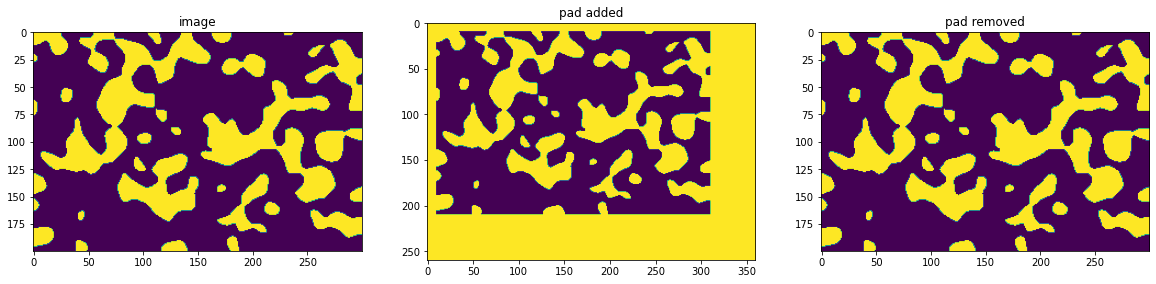

In [3]:
r"""
Example
"""

pad_width = [10,50]

im = ps.generators.blobs([200,300], porosity = 0.3)
print("shape original:", im.shape)
im1 = np.pad(im, pad_width, mode = "constant", constant_values = 1)
print("shape padded:", im1.shape)
im3 = unpad(im1, pad_width)
print("shape new unpad:", im3.shape)


fig, ax = plt.subplots(1, 3, figsize=[20,20]);
ax[0].imshow(im);
ax[1].imshow(im1);
ax[2].imshow(im3);
ax[0].set_title('image')
ax[1].set_title('pad added')
ax[2].set_title('pad removed')
#"""